### Sentiment Analysis
LSTM

In [1]:
# importing libraries
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Default GPU Device: /device:GPU:0


In [2]:
# load bitcoin sentiment dataset
df_btc = pd.read_csv("C:/Users/User/Documents/C2001/FIT3161_3162/FIT3161/dataset/sentiment/cleanprep.csv",header=None)
df_btc.dtypes

0     object
1     object
2     object
3    float64
4    float64
dtype: object

In [3]:
# dropping null rows
df_btc = df_btc.dropna()
df_btc.isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [4]:
df_btc.head()

,0,1,2,3,4
0,2018-07-11 19:35:15.363270,b'tj',"b""Next two weeks prob v boring (climb up to 9k...",0.007273,0.590909
1,2018-07-11 19:35:15.736769,b'Kool_Kheart',b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,0.000000,0.000000
2,2018-07-11 19:35:15.744769,b'Gary Lang',b'Duplicate skilled traders automatically with...,0.625000,0.500000
3,2018-07-11 19:35:15.867339,b'Jobs in Fintech',b'Project Manager - Technical - FinTech - Cent...,0.000000,0.175000
4,2018-07-11 19:35:16.021448,b'ERC20',"b'Coinbase App Downloads Drop, Crypto Hype Fad...",0.333333,0.500000


In [5]:
# minimize the dataset by selecting data 2020
df_btc[0] = pd.to_datetime(df_btc[0])
start_date = '2018-07-11'
end_date = '2018-07-12'
mask = (df_btc[0] > start_date) & (df_btc[0] <= end_date)

df_btc = df_btc.loc[mask]

In [6]:
df_btc.head()

,0,1,2,3,4
0,2018-07-11 19:35:15.363270,b'tj',"b""Next two weeks prob v boring (climb up to 9k...",0.007273,0.590909
1,2018-07-11 19:35:15.736769,b'Kool_Kheart',b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,0.000000,0.000000
2,2018-07-11 19:35:15.744769,b'Gary Lang',b'Duplicate skilled traders automatically with...,0.625000,0.500000
3,2018-07-11 19:35:15.867339,b'Jobs in Fintech',b'Project Manager - Technical - FinTech - Cent...,0.000000,0.175000
4,2018-07-11 19:35:16.021448,b'ERC20',"b'Coinbase App Downloads Drop, Crypto Hype Fad...",0.333333,0.500000


Preparing training data

In [7]:
X_train, Y_train = df_btc[2], df_btc[3]

# testing
index = 25
print(X_train[index], Y_train[index])

b'@tal51851805\n@Le_Ehmad @CryptoSchoolPak  @salihughes @io_eth @altcharts \n#ETHP #Airdrop #EthereumPro #ETH #Bitcoin\xe2\x80\xa6 https://t.co/ytm1cwDSox' 0.0


In [8]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweets.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_btc[2].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45254 unique tokens.


In [9]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df_btc[2].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (18343, 250)


In [10]:
Y = pd.get_dummies(df_btc[3]).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (18343, 660)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16508, 250) (16508, 660)
(1835, 250) (1835, 660)


In [12]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, SpatialDropout1D, LSTM, Bidirectional
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(LSTM(128, input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(SpatialDropout1D(0.6))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='tanh'))

opt = keras.optimizers.Adam(learning_rate=0.00005)


model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 lstm (LSTM)                 (None, 250, 128)          117248    
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 128)         0         
 ropout1D)                                                       
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 128)               132096    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,249,473
Trainable params: 5,249,473
Non-trainable params: 0
______________________________________________

In [13]:
epochs = 50
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)


Epoch 1/50
233/233 [==============================] - 19s 49ms/step - loss: 0.0184 - accuracy: 0.9985 - val_loss: 0.0161 - val_accuracy: 0.9985
Epoch 2/50
233/233 [==============================] - 10s 45ms/step - loss: 0.0170 - accuracy: 0.9985 - val_loss: 0.0132 - val_accuracy: 0.9985
Epoch 3/50
233/233 [==============================] - 11s 45ms/step - loss: 0.0173 - accuracy: 0.9985 - val_loss: 0.0254 - val_accuracy: 0.9985
Epoch 4/50
233/233 [==============================] - 10s 45ms/step - loss: 0.0198 - accuracy: 0.9985 - val_loss: 0.0200 - val_accuracy: 0.9985
Epoch 5/50
233/233 [==============================] - 10s 45ms/step - loss: 0.0175 - accuracy: 0.9985 - val_loss: 0.0158 - val_accuracy: 0.9985
Epoch 6/50
233/233 [==============================] - 10s 45ms/step - loss: 0.0164 - accuracy: 0.9985 - val_loss: 0.0139 - val_accuracy: 0.9985
Epoch 7/50
233/233 [==============================] - 11s 45ms/step - loss: 0.0155 - accuracy: 0.9985 - val_loss: 0.0160 - val_accuracy:

In [14]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

58/58 [==============================] - 1s 17ms/step - loss: 0.0114 - accuracy: 0.9985
Test set
  Loss: 0.011
  Accuracy: 0.998


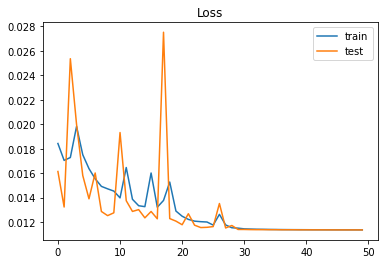

In [73]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

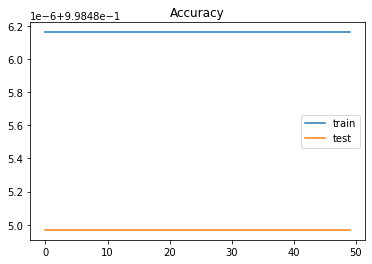

In [16]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [51]:
new_tweets = pd.read_csv(r"C:\Users\User\Documents\C2001\FIT3161_3162\FIT3161\20220124_081532_crypto_tweets.csv") 
new_tweets.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,PovarezhkaRu,"Приветствую всех, на кулинарном портале https:...",NaN,0,0,3,2021-10-25 17:53:01+00:00,2022-01-23 18:55:42+00:00,22,🌎⚠️🔒 Check your VerusID Vault anywhere in the ...,"[{'text': 'cryptocurrency', 'indices': [95, 11..."
1,Z3roDoG3,NaN,NaN,687,61,1474,2018-09-25 05:18:25+00:00,2022-01-23 18:55:41+00:00,160,One reason I love crypto so much is because ev...,[]
2,jamorantq,NaN,NaN,195,1,47,2020-10-24 17:29:35+00:00,2022-01-23 18:55:40+00:00,24270,🎆🎆Happy New Year in advance!\nWe will draw 10 ...,[]
3,_Burak_Dogu,$BICO $SXP $HMT $ATLAS $RACA $KIN,Sarıyer,638,52,1435,2013-02-02 19:46:05+00:00,2022-01-23 18:55:37+00:00,25718,🚀 Airdrop continue:Airdrop：https://t.co/NePHh1...,[]
4,EnginSenli1,NaN,Kocaeli,231,52,224,2016-08-04 16:06:39+00:00,2022-01-23 18:55:36+00:00,1,#etalbit\n#vabeey\n#denaar\n#scammer\n#cryptoc...,"[{'text': 'etalbit', 'indices': [16, 24]}, {'t..."


In [52]:
new_tweet = new_tweets.text
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

In [53]:
new_tweets['Sentiment'] = pred

In [54]:
new_tweets.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,Sentiment
0,PovarezhkaRu,"Приветствую всех, на кулинарном портале https:...",NaN,0,0,3,2021-10-25 17:53:01+00:00,2022-01-23 18:55:42+00:00,22,🌎⚠️🔒 Check your VerusID Vault anywhere in the ...,"[{'text': 'cryptocurrency', 'indices': [95, 11...",0.001553
1,Z3roDoG3,NaN,NaN,687,61,1474,2018-09-25 05:18:25+00:00,2022-01-23 18:55:41+00:00,160,One reason I love crypto so much is because ev...,[],0.001605
2,jamorantq,NaN,NaN,195,1,47,2020-10-24 17:29:35+00:00,2022-01-23 18:55:40+00:00,24270,🎆🎆Happy New Year in advance!\nWe will draw 10 ...,[],0.001617
3,_Burak_Dogu,$BICO $SXP $HMT $ATLAS $RACA $KIN,Sarıyer,638,52,1435,2013-02-02 19:46:05+00:00,2022-01-23 18:55:37+00:00,25718,🚀 Airdrop continue:Airdrop：https://t.co/NePHh1...,[],0.001478
4,EnginSenli1,NaN,Kocaeli,231,52,224,2016-08-04 16:06:39+00:00,2022-01-23 18:55:36+00:00,1,#etalbit\n#vabeey\n#denaar\n#scammer\n#cryptoc...,"[{'text': 'etalbit', 'indices': [16, 24]}, {'t...",0.001501


In [55]:
new_tweets.tweetcreatedts = pd.to_datetime(new_tweets.tweetcreatedts)
new_tweets = new_tweets.resample('1T', on='tweetcreatedts').agg({'Sentiment':'mean'})

In [57]:
new_tweets

,Sentiment
tweetcreatedts,
2022-01-23 18:41:00+00:00,0.001575
2022-01-23 18:42:00+00:00,0.001559
2022-01-23 18:43:00+00:00,0.001570
2022-01-23 18:44:00+00:00,0.001564
2022-01-23 18:45:00+00:00,0.001566
...,...
2022-01-23 23:55:00+00:00,0.001526
2022-01-23 23:56:00+00:00,0.001556
2022-01-23 23:57:00+00:00,0.001571


In [61]:
new_tweets['daily_sentiment_change'] = (new_tweets['Sentiment'].shift(1)-new_tweets['Sentiment'])/new_tweets['Sentiment'].shift(1)

In [64]:
new_tweets = new_tweets.dropna()

In [69]:
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x=new_tweets.index, y=new_tweets.daily_sentiment_change,name='MA Sentiment Change (%)')])
fig.update_layout(title="Bitcoin Price vs Sentiment")
fig.show()

In [70]:
import yfinance as yf
import pendulum

pd.options.display.max_rows=10  # To decrease printouts
start = pendulum.parse('2022-01-23 18:00').add(hours=8)  # My tz is UTC+08:00, original TZ UTC-04:00. So adds to my local time 7 hours
end = pendulum.parse('2022-01-23 23:59').add(hours=8) # Same
eth = yf.download(tickers="ETH-USD", interval="1m", start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [71]:
eth['percent_change_daily_close'] = (eth['Close'].shift(1)-eth['Close'])/eth['Close'].shift(1)


In [72]:
fig.add_trace(go.Scatter(x=eth.index, 
                         y=eth['percent_change_daily_close'], 
                         opacity=0.7, 
                         line=dict(color='orange', width=2), 
                         name='Bitcoin Price Change(%)'))